In [1]:
# Tutorial from:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.012*"write" + 0.012*"organization" + 0.011*"article" + 0.009*"time" + '
  '0.008*"first" + 0.007*"tell" + 0.007*"new" + 0.006*"give" + 0.006*"bike" + '
  '0.006*"look"'),
 (1,
  '0.010*"christian" + 0.010*"people" + 0.010*"believe" + 0.009*"god" + '
  '0.008*"law" + 0.007*"question" + 0.007*"book" + 0.006*"exist" + '
  '0.005*"claim" + 0.005*"answer"'),
 (2,
  '0.022*"armenian" + 0.009*"israel" + 0.008*"people" + 0.008*"israeli" + '
  '0.007*"kill" + 0.007*"state" + 0.006*"turk" + 0.006*"government" + '
  '0.006*"center" + 0.005*"arab"'),
 (3,
  '0.021*"team" + 0.021*"game" + 0.014*"hockey" + 0.011*"player" + '
  '0.010*"play" + 0.010*"win" + 0.010*"nhl" + 0.010*"hawk" + 0.010*"season" + '
  '0.008*"year"')]


In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic #.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9451,"write, organization, article, time, first, tell, new, give, bike, look","[irwin, arnstein, recommendation, duc, summary, worth, expire, sit, gmt, organization, computrac..."
1,1,0.0,0.6438,"write, organization, article, time, first, tell, new, give, bike, look","[eric, townsend, insurance, lotsa_point, reply, message, mon, apr_gmt, organization, netcom_onli..."
2,2,0.0,0.5689,"write, organization, article, time, first, tell, new, give, bike, look","[gary_dare, abc_coverage, reply, gary_dare, organization, phd, hall, caleb, cohen, write, boy, e..."
3,3,2.0,0.6712,"armenian, israel, people, israeli, kill, state, turk, government, center, arab","[naftaly_stramer, peace_talk, reply, organization, israeline, today, maariv, report, yesterday, ..."
4,4,1.0,0.5224,"christian, people, believe, god, law, question, book, exist, claim, answer","[question, authority, trendy, liberal, feminist, tendency, fact, basically, agree, rebut, write,..."
5,5,0.0,0.5094,"write, organization, article, time, first, tell, new, give, bike, look","[harrass, work, prayer, reply, organization, university, chicago, repeat, emphasize, someone_els..."
6,6,0.0,0.9799,"write, organization, article, time, first, tell, new, give, bike, look","[andrew_infante, ok, little_hasty, organization, duke, university, durham, apparently, last, pos..."
7,7,1.0,0.7430,"christian, people, believe, god, law, question, book, exist, claim, answer","[james_sledd, afterlife, organization, social, science, computing, way, look, die, release, arc,..."
8,8,3.0,0.5198,"team, game, hockey, player, play, win, nhl, hawk, season, year","[canadien, stanley_cup, organization, canada, dean, pereira, write, kind, team, montreal, cup, p..."
9,9,3.0,0.9063,"team, game, hockey, player, play, win, nhl, hawk, season, year","[steve_gallichio, possible, canadian, wc, team, organization, cadkey_inc, point, team, canadian,..."


In [7]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9914,"write, organization, article, time, first, tell, new, give, bike, look","[marvin, jaster, sale, sunsol, semi, harris, com, organization, harris, semiconductor, melbourne..."
1,1.0,0.9770,"christian, people, believe, god, law, question, book, exist, claim, answer","[arrogance, christian, organization, read, carol, response, interpretation, peter, timothy, gala..."
2,2.0,0.9918,"armenian, israel, people, israeli, kill, state, turk, government, center, arab","[serdar_argic, armenian, genocide, muslim, people, article, reply, article, panos_tamamidi, writ..."
3,3.0,0.9979,"team, game, hockey, player, play, win, nhl, hawk, season, year","[bryan, strouse, nhl, result, game, play, organization, keyword, thursday, night, boxscore, nhl,..."


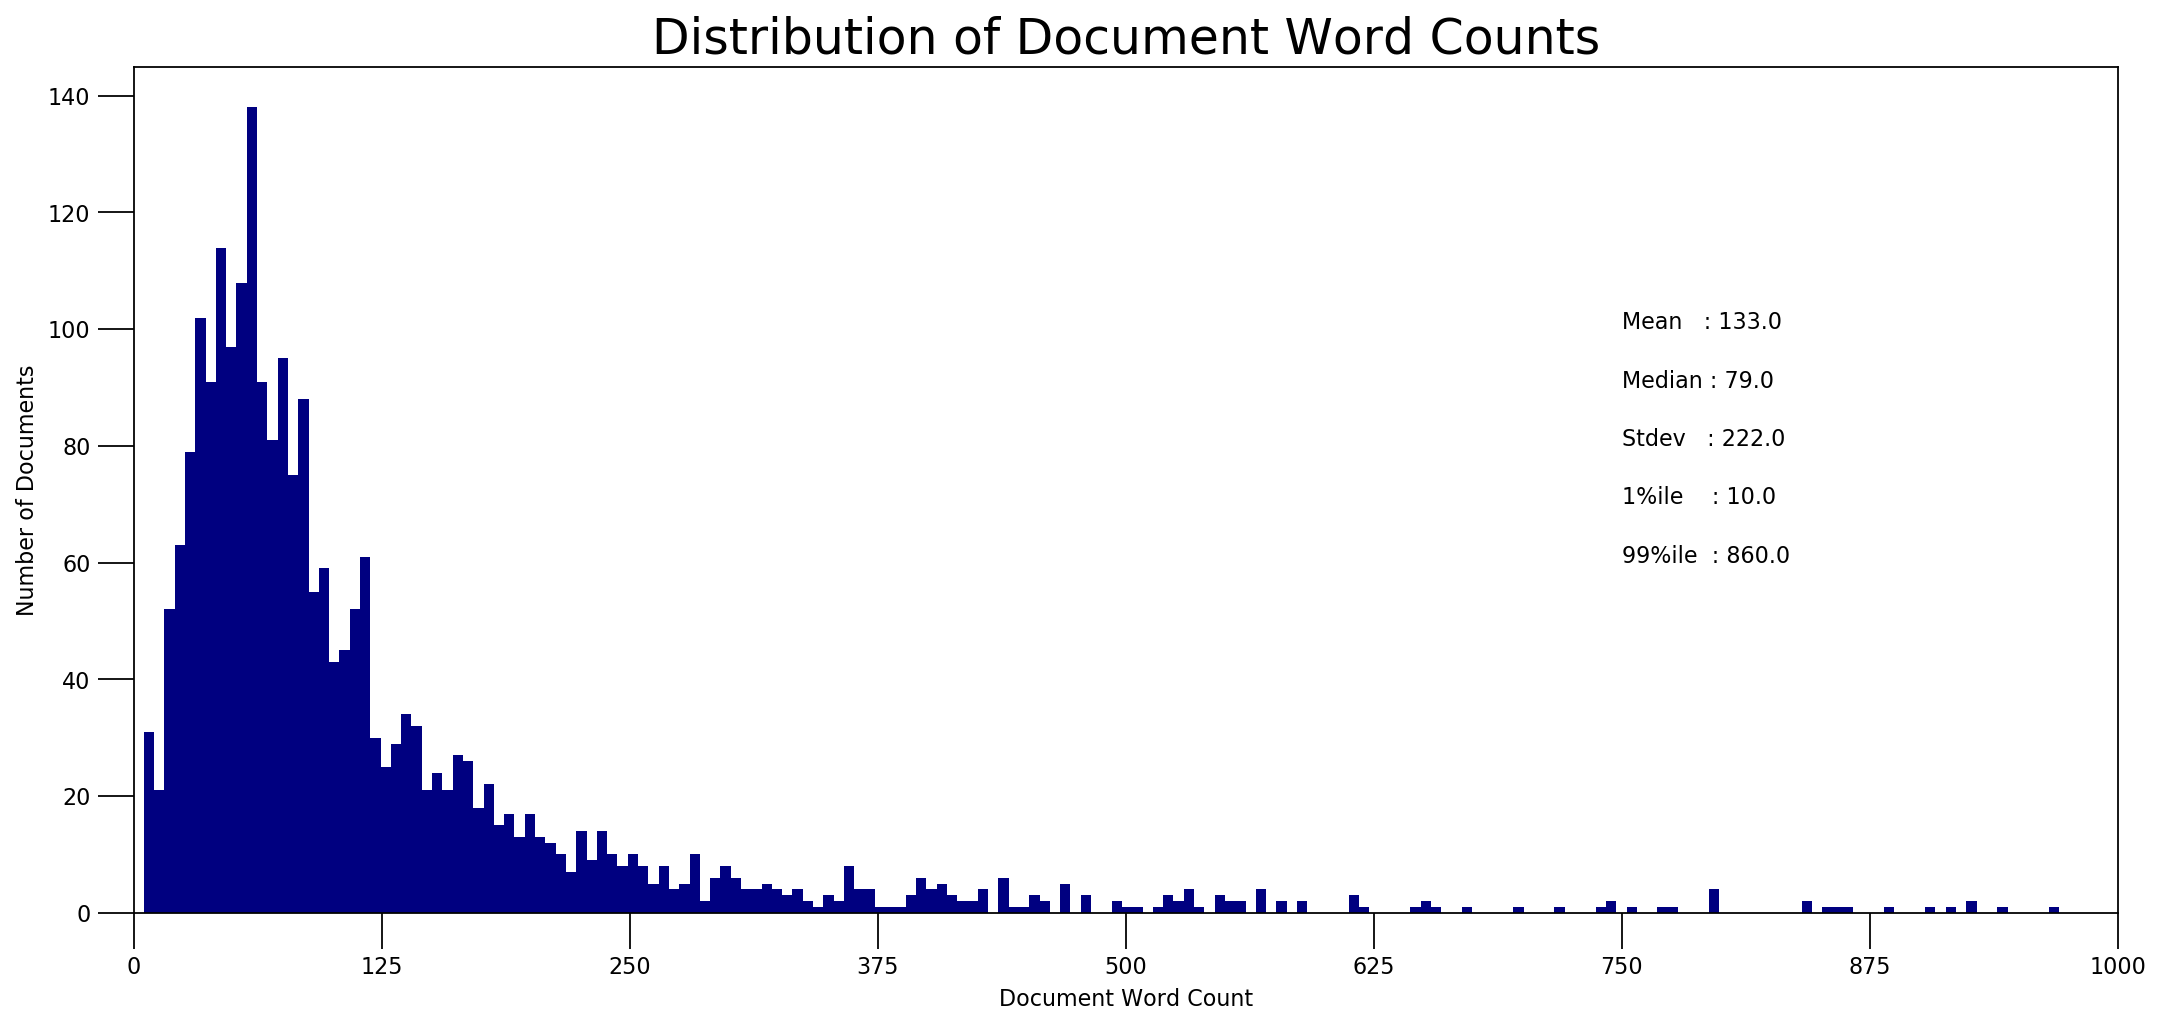

In [8]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/Users/tharsen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


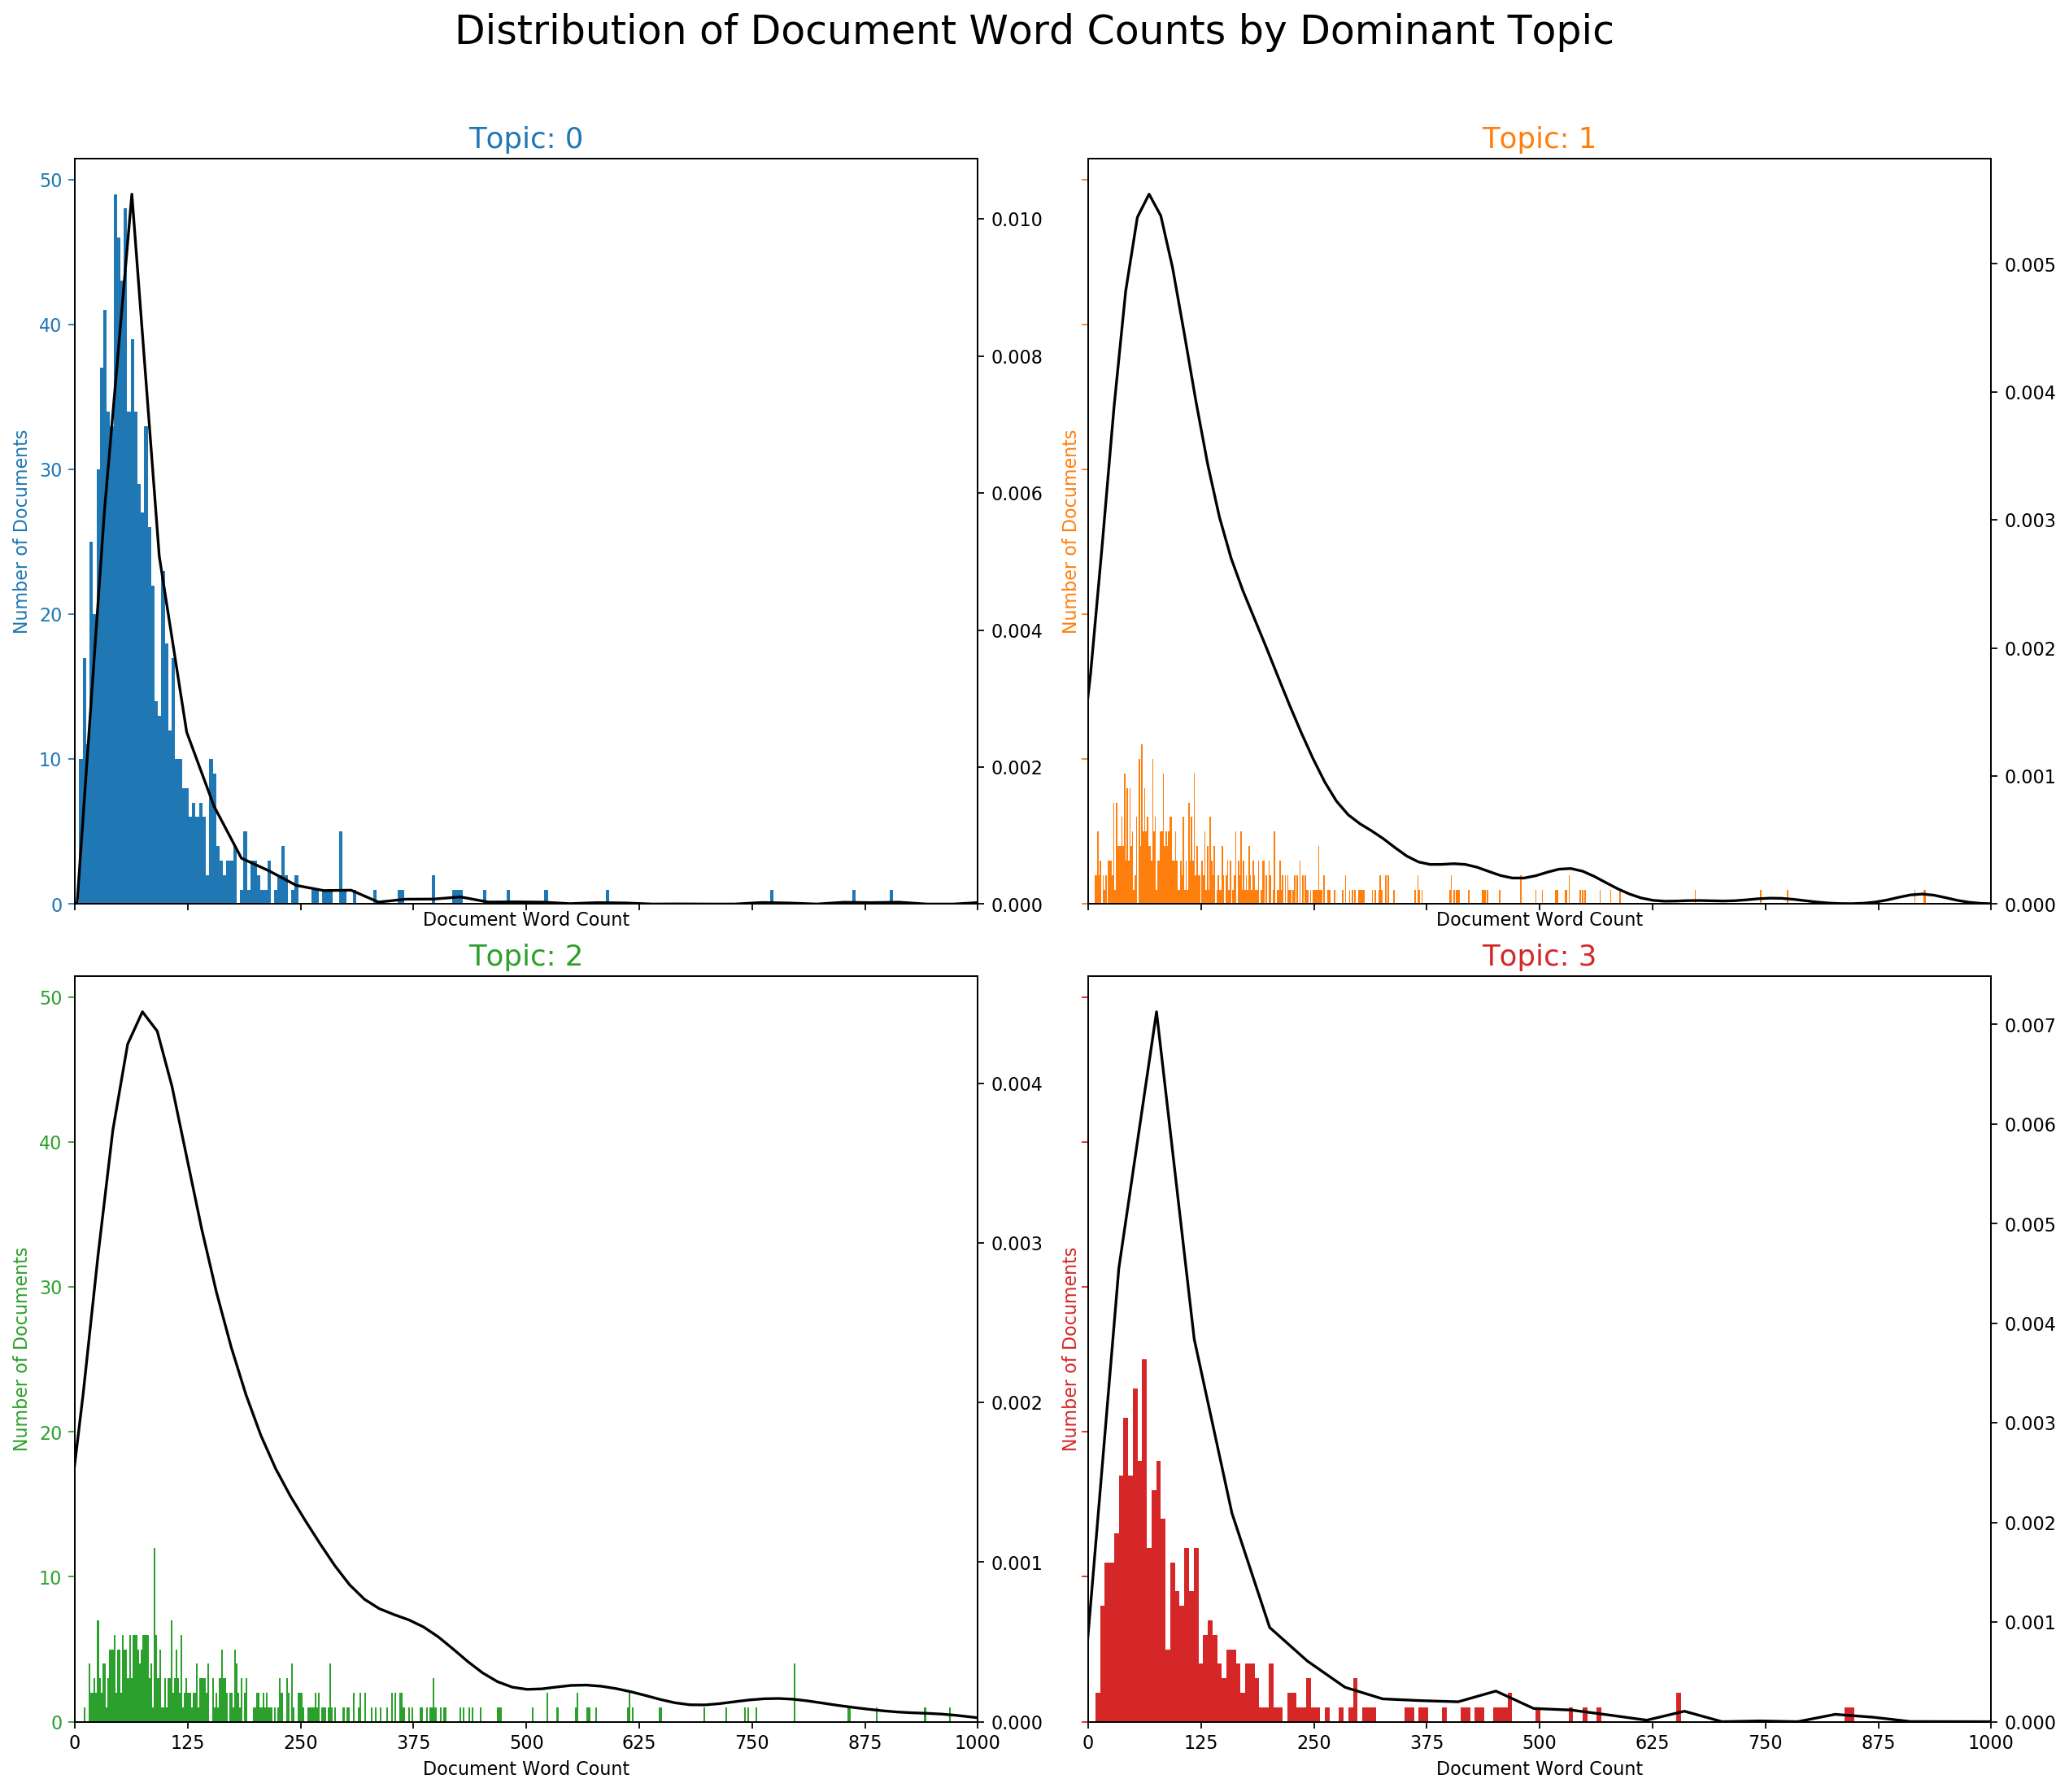

In [9]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

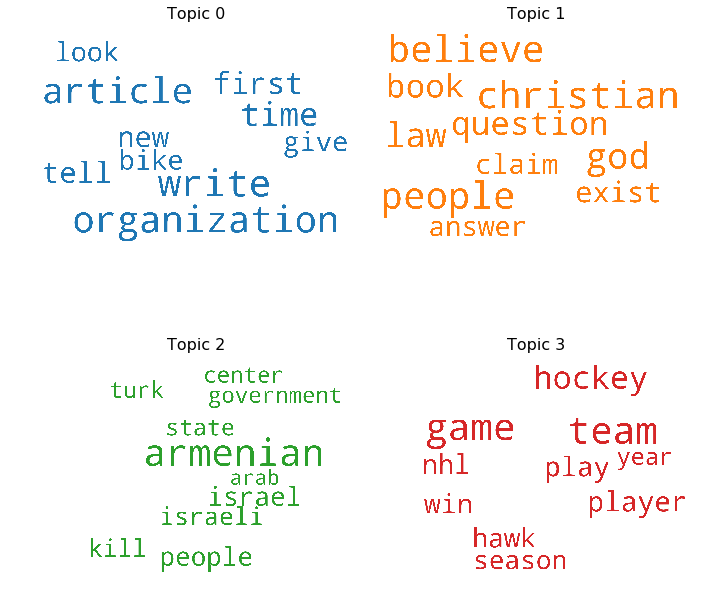

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

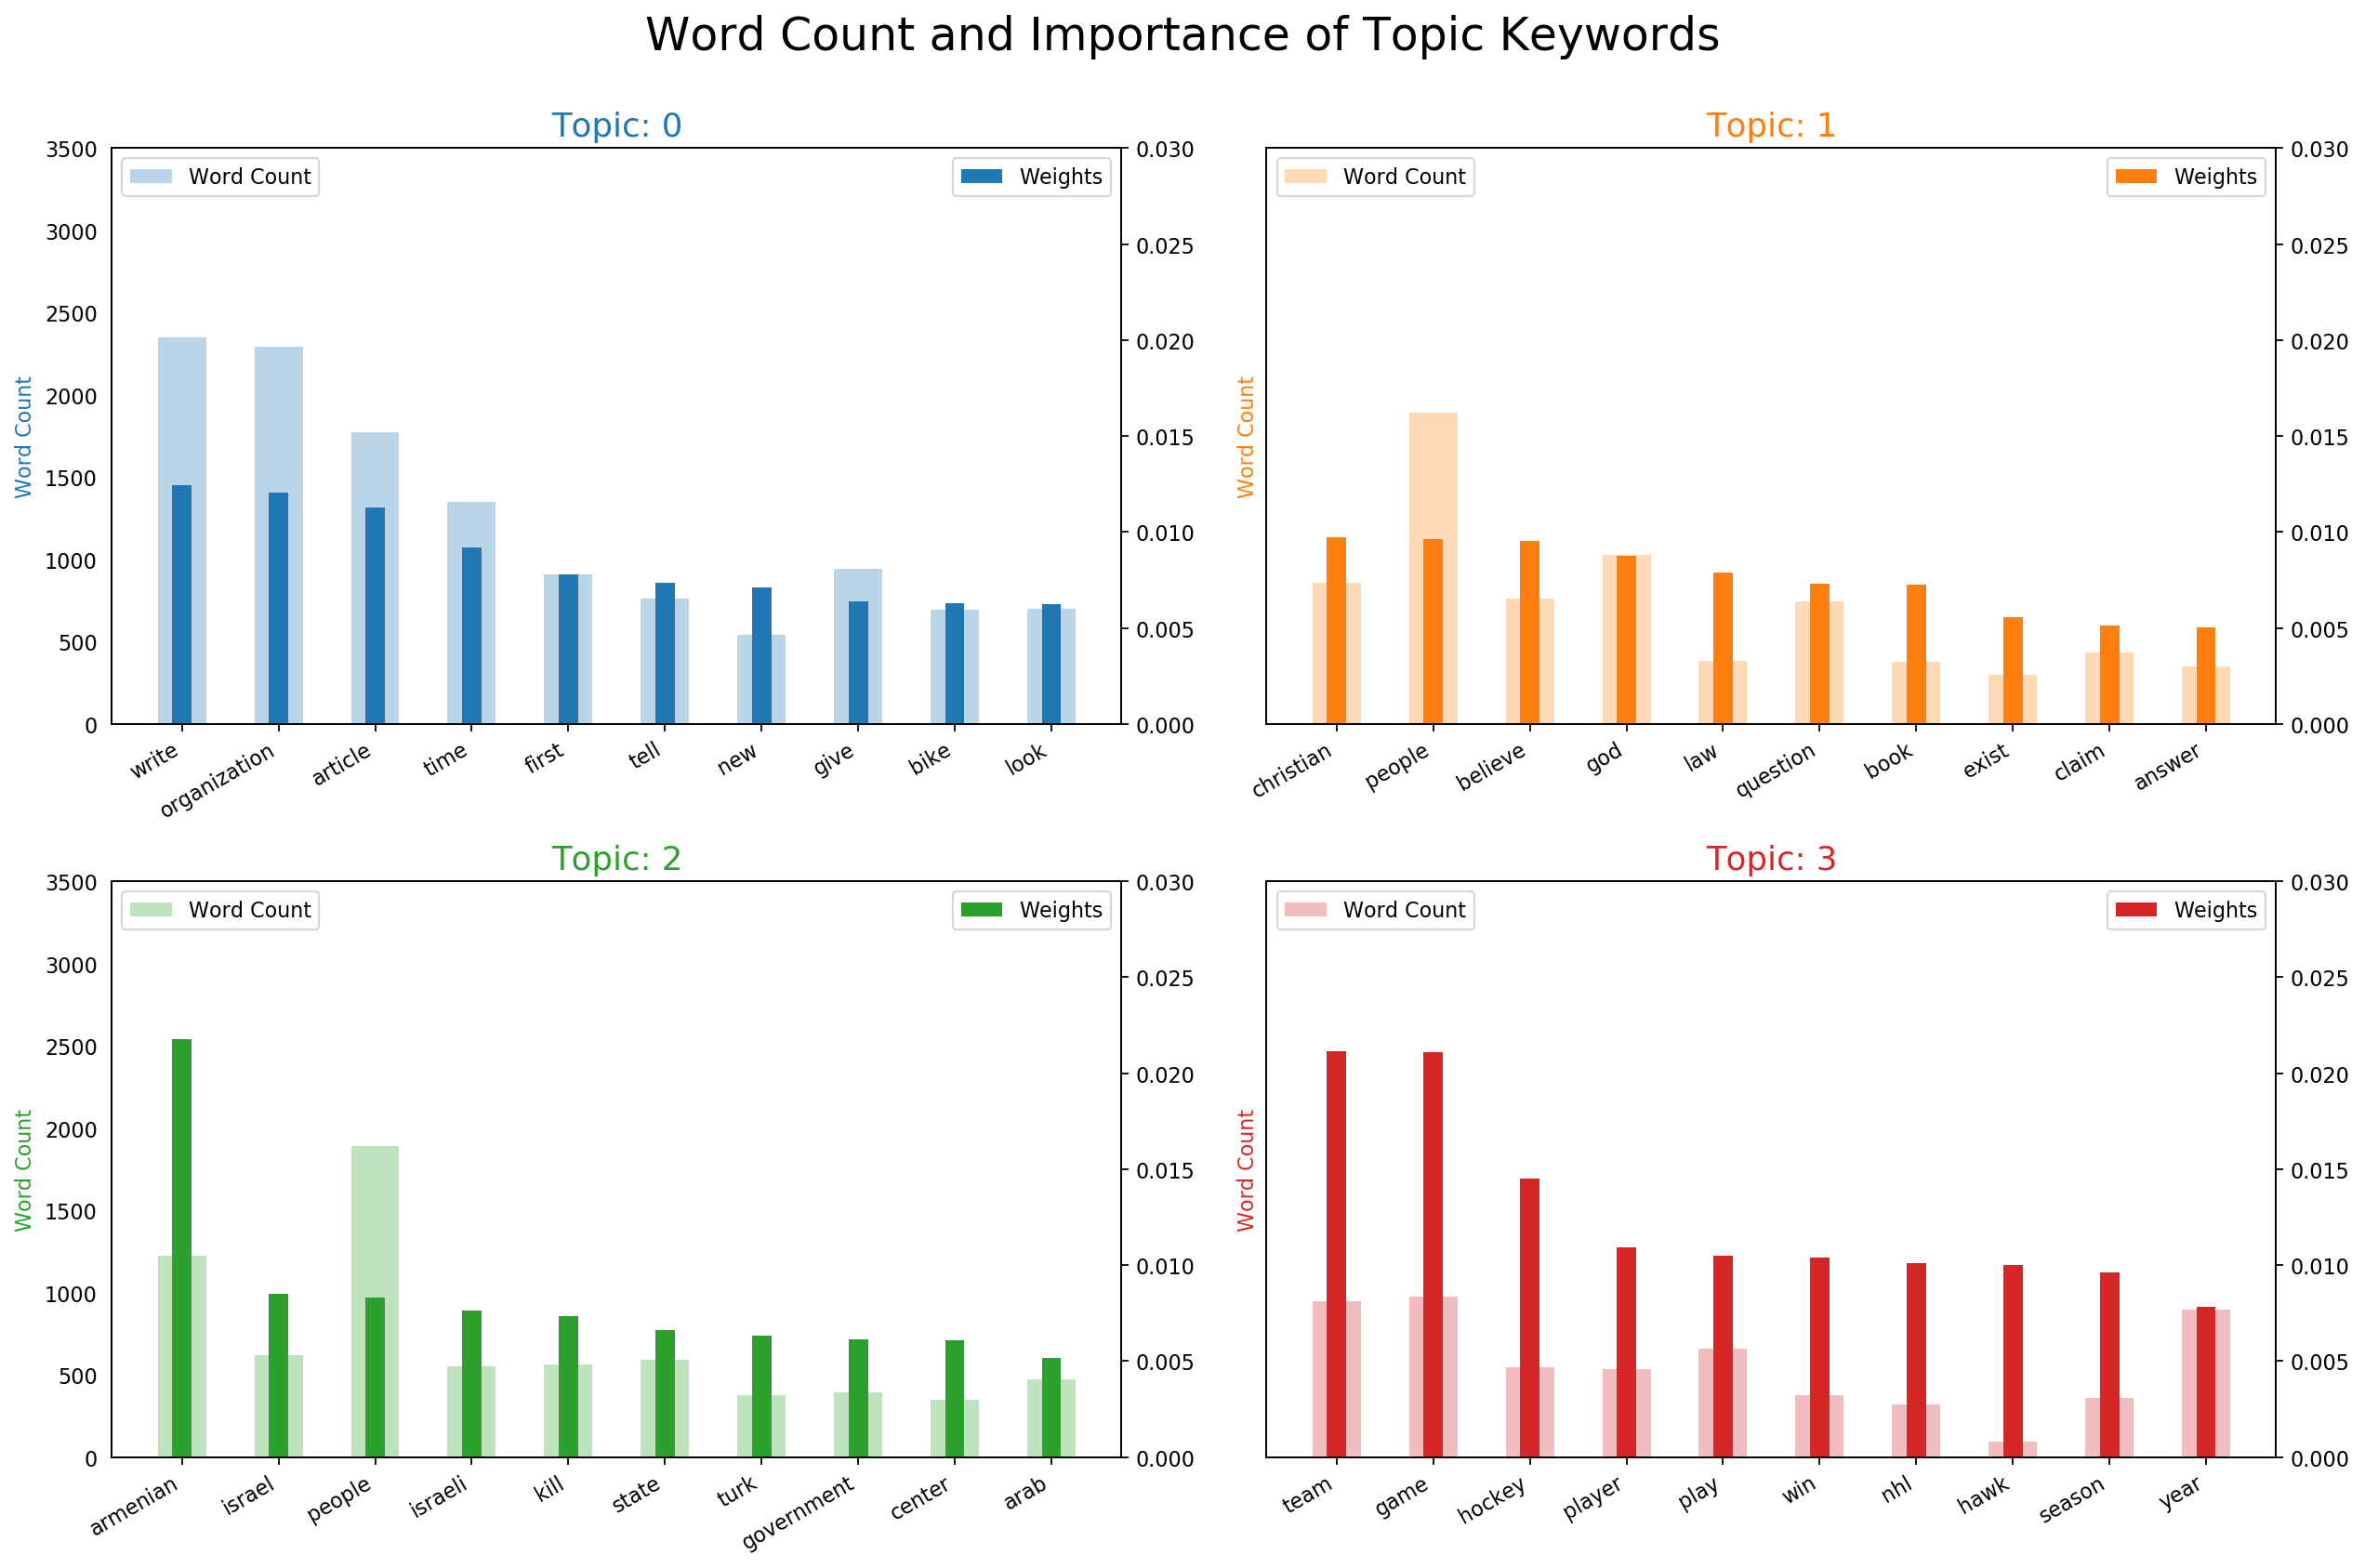

In [11]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

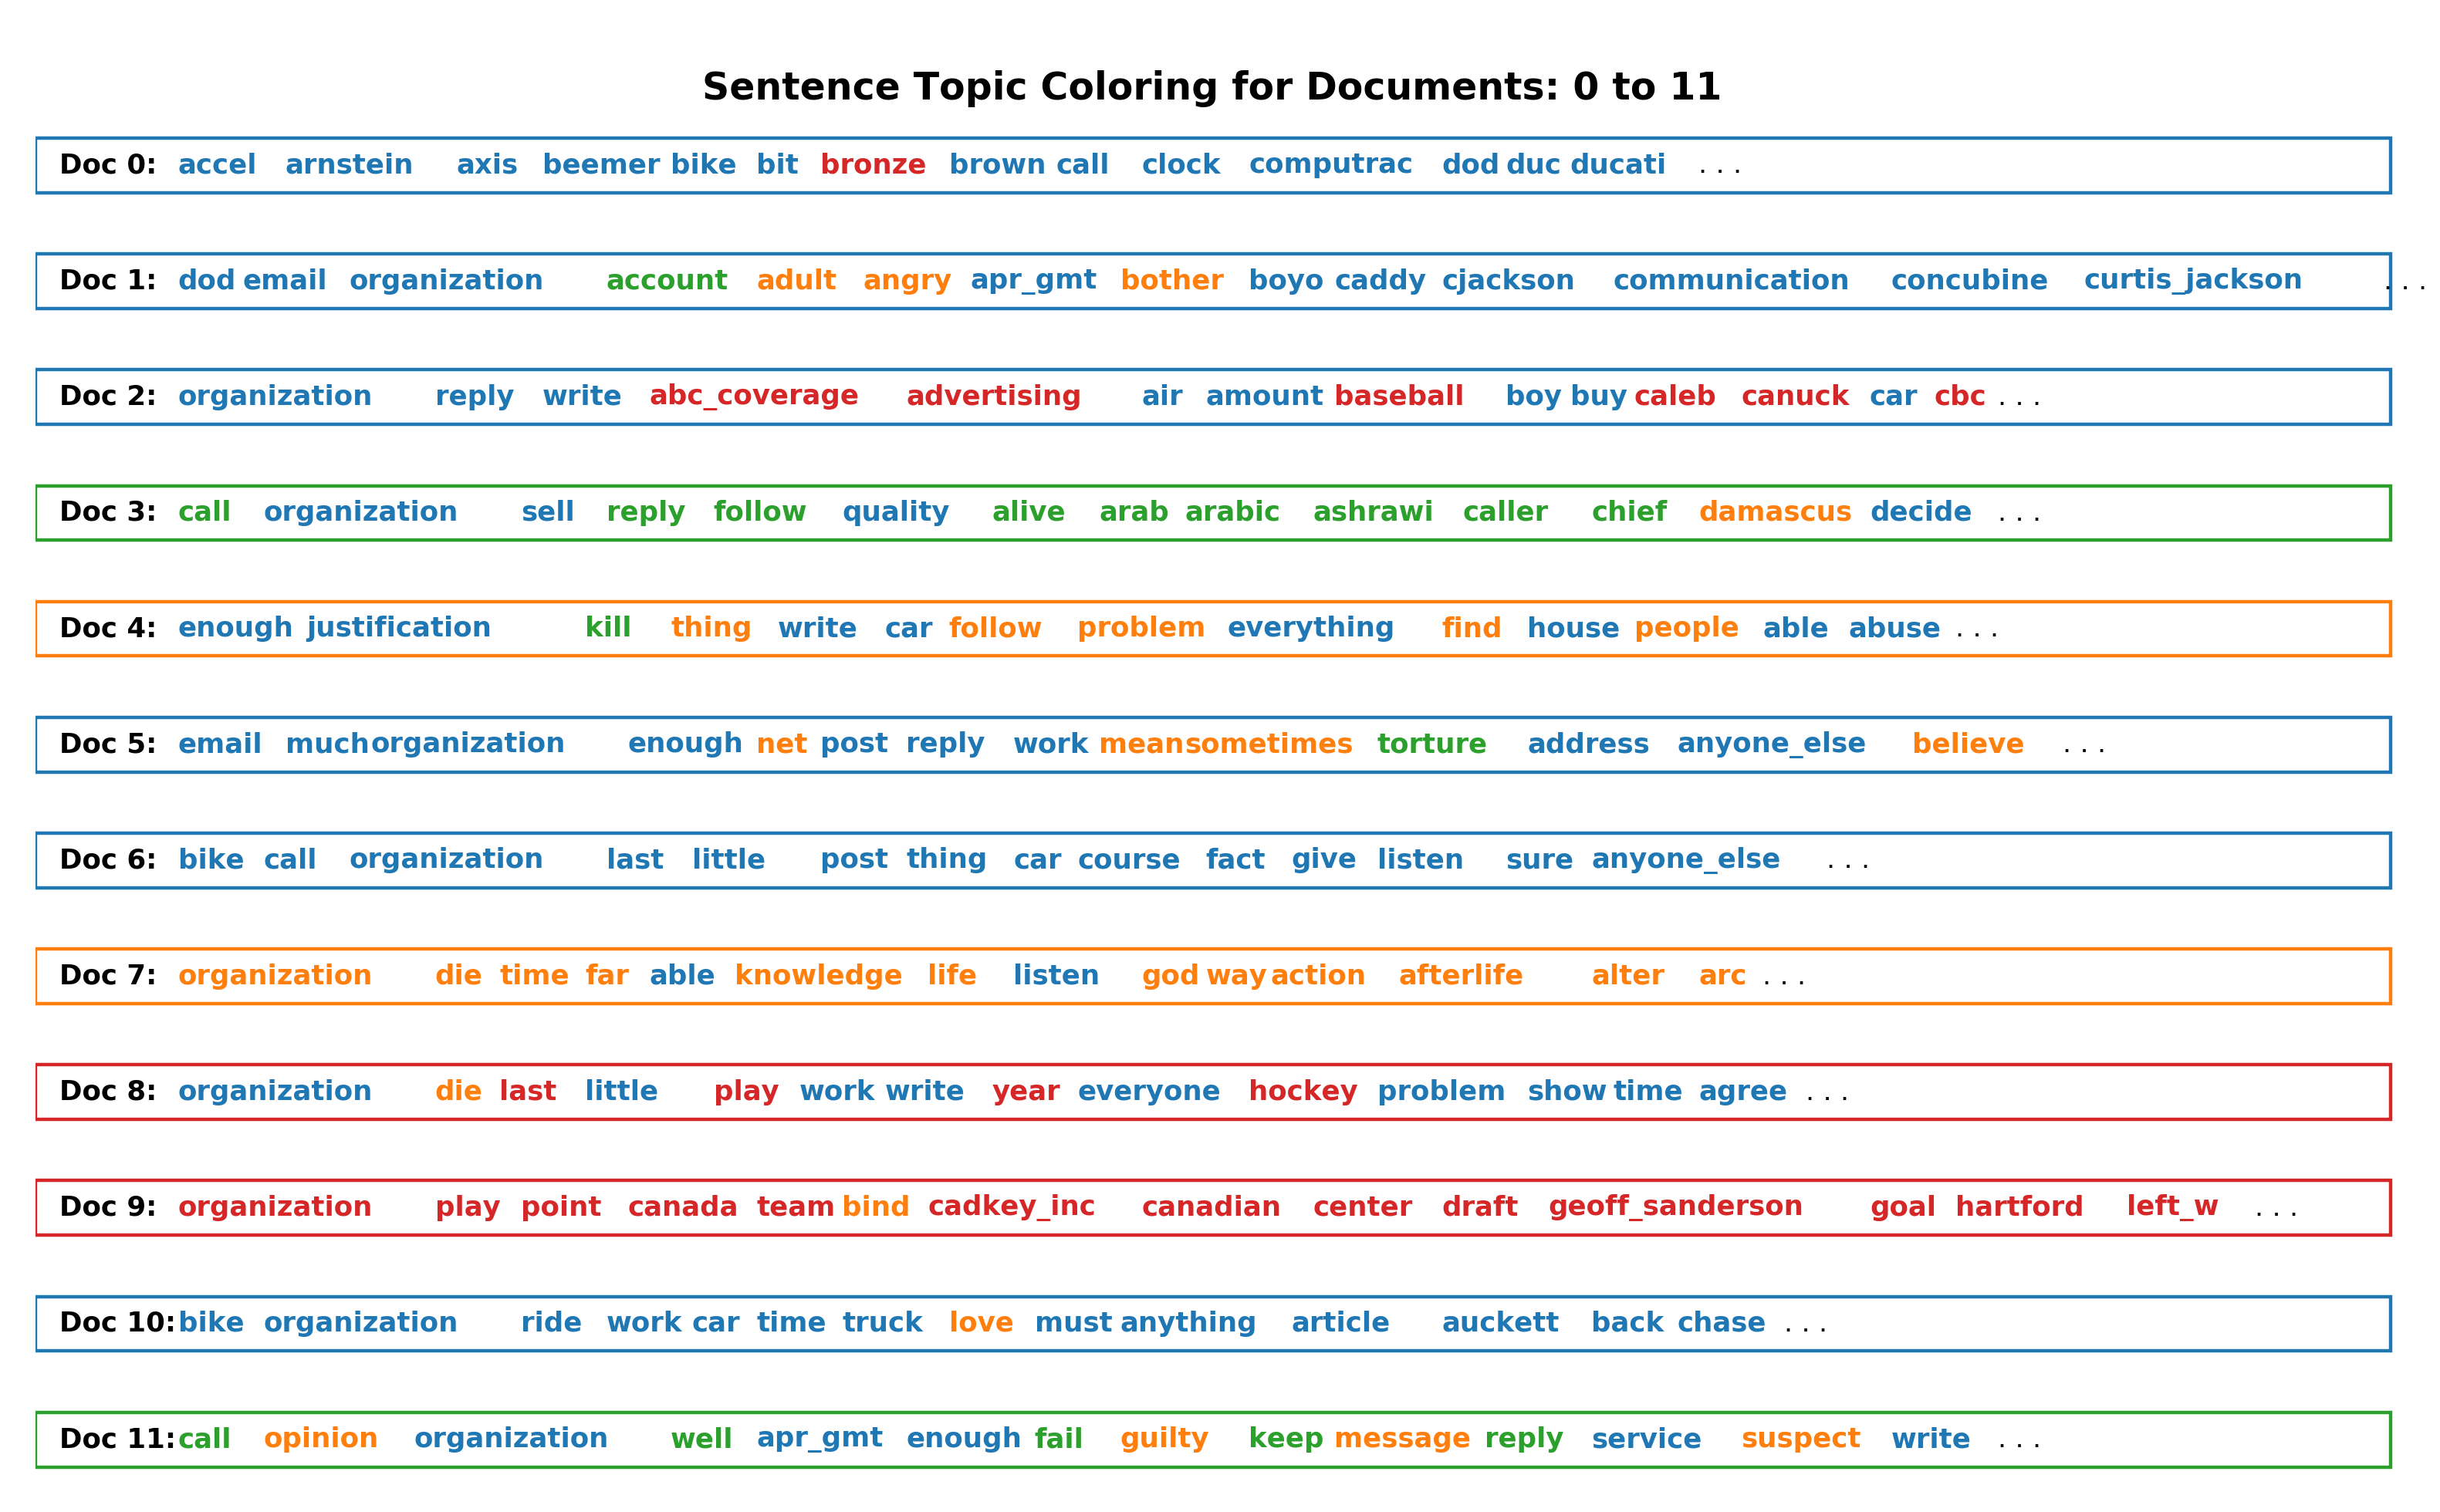

In [12]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [13]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


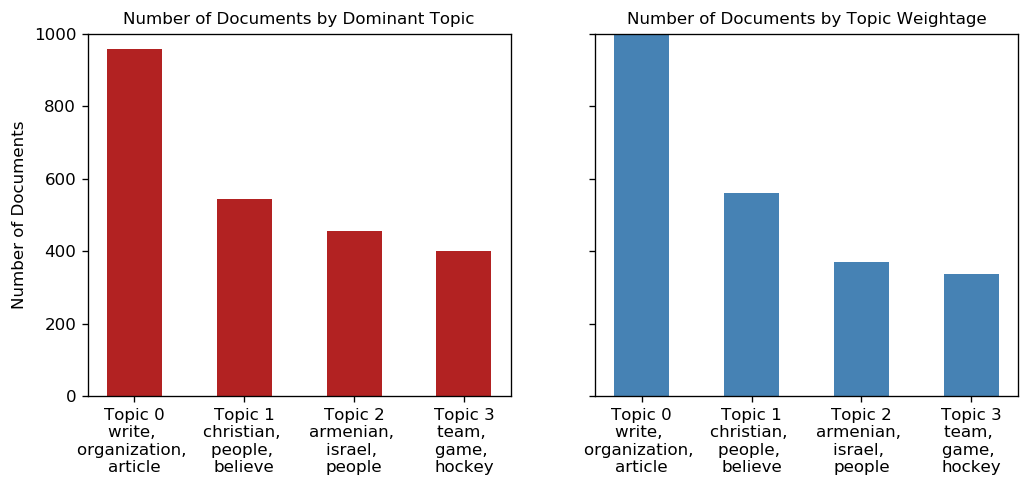

In [14]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [15]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2357 samples in 0.005s...
[t-SNE] Computed neighbors for 2357 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2357
[t-SNE] Computed conditional probabilities for sample 2000 / 2357
[t-SNE] Computed conditional probabilities for sample 2357 / 2357
[t-SNE] Mean sigma: 0.016818
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.403511
[t-SNE] Error after 1000 iterations: 0.505242


Loading BokehJS ...

In [16]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      37.726830        1       1 -0.072003  0.195913
1      26.793486        1       2 -0.175696  0.063289
2      21.977360        1       3 -0.106456 -0.254062
3      13.502322        1       4  0.354155 -0.005140, topic_info=      Category         Freq           Term        Total  loglift  logprob
term                                                                     
1483   Default  1501.000000       armenian  1501.000000  30.0000  30.0000
526    Default   894.000000           team   894.000000  29.0000  29.0000
1181   Default   893.000000           game   893.000000  28.0000  28.0000
157    Default   613.000000         hockey   613.000000  27.0000  27.0000
965    Default   816.000000      christian   816.000000  26.0000  26.0000
382    Default   801.000000        believe   801.000000  25.0000  25.0000
394    Default   733.000000            god   733.000000  24.0000  24.0000
2521   Default   463.000000         player   463.000000  23.0000  23.0000
712    Default   586.000000         israel   586.000000  22.0000  22.0000
98     Default   444.000000           play   444.000000  21.0000  21.0000
529    Default   440.000000            win   440.000000  20.0000  20.0000
724    Default   661.000000            law   661.000000  19.0000  19.0000
1408   Default   427.000000            nhl   427.000000  18.0000  18.0000
2946   Default   424.000000           hawk   424.000000  17.0000  17.0000
549    Default   406.000000         season   406.000000  16.0000  16.0000
2312   Default   524.000000        israeli   524.000000  15.0000  15.0000
1063   Default   615.000000           book   615.000000  14.0000  14.0000
89     Default   506.000000           kill   506.000000  13.0000  13.0000
4      Default   743.000000           bike   743.000000  12.0000  12.0000
472    Default   736.000000           look   736.000000  11.0000  11.0000
326    Default   865.000000            new   865.000000  10.0000  10.0000
436    Default  1038.000000          first  1038.000000   9.0000   9.0000
1649   Default   436.000000           turk   436.000000   8.0000   8.0000
366    Default   927.000000           tell   927.000000   7.0000   7.0000
682    Default   421.000000     government   421.000000   6.0000   6.0000
337    Default   813.000000       question   813.000000   5.0000   5.0000
674    Default   467.000000          exist   467.000000   4.0000   4.0000
231    Default  1763.000000         people  1763.000000   3.0000   3.0000
128    Default   975.000000           year   975.000000   2.0000   2.0000
2511   Default   274.000000         league   274.000000   1.0000   1.0000
...        ...          ...            ...          ...      ...      ...
548     Topic4   222.437210          score   223.173065   1.9990  -5.2478
98      Topic4   442.800568           play   444.292847   1.9989  -4.5594
94      Topic4   222.193878            mon   222.979584   1.9988  -5.2489
2946    Topic4   423.088104           hawk   424.621979   1.9987  -4.6049
17195   Topic4   183.557526            nyr   184.263382   1.9985  -5.4400
543     Topic4   176.480530        playoff   177.191177   1.9983  -5.4793
1916    Topic4   171.455368            chi   172.160828   1.9982  -5.5082
1273    Topic4   166.547287     pittsburgh   167.273560   1.9980  -5.5372
5005    Topic4   160.342880            pit   161.049118   1.9979  -5.5752
5030    Topic4   157.378967            tor   158.084717   1.9978  -5.5938
4940    Topic4   154.176056            bos   154.881119   1.9977  -5.6144
2505    Topic4   169.193130  hockey_league   169.969193   1.9977  -5.5214
3936    Topic4   153.803284            nyi   154.509171   1.9977  -5.6168
3938    Topic4   151.308975            stl   152.013931   1.9977  -5.6332
1375    Topic4   162.991180     defenseman   163.783203   1.9975  -5.5588
4954    Topic4   142.012726            det   142.717224   1.9974  -5.6966
13027  